# Standard Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
from treeinterpreter import treeinterpreter as ti

In [3]:
from os import system
from scipy.spatial.distance import euclidean
from catboost import Pool, CatBoostClassifier

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import naive_bayes

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2

In [6]:
# Useful trick when running things that take a long time.
#system('say I am done!');

# Read in CSVs, create DFs

In [276]:
train = pd.read_csv('train 3.csv')
train_clas = pd.read_csv('train 3.csv')

In [277]:
test = pd.read_csv('test.csv')
test_clas = pd.read_csv('test.csv')

In [278]:
col_list = train.columns

In [279]:
col_list = list(col_list)[1:]

In [280]:
#full = pd.read_csv('covtype.data', names=col_list)

In [281]:
#only ran this once to get create the full csv file for use in model implementation on the flask app.
#full.to_csv('full_cols.csv')

In [282]:
#full_clas = full

In [283]:
#convert Id & Cover Type to strings, since they are not numeric features
train['Id'] = train['Id'].apply(str)
train['Cover_Type'] = train['Cover_Type'].apply(str)
#full['Cover_Type'] = full['Cover_Type'].apply(str)
test['Id'] = test['Id'].apply(str)
test_clas['Id'] = test_clas['Id'].apply(str)
train_clas['Id'] = train_clas['Id'].apply(str)
train_clas['Cover_Type'] = train_clas['Cover_Type'].apply(str)
#full_clas['Cover_Type'] = full_clas['Cover_Type'].apply(str)
test_clas['Cover_Type_Name'] = 'TBD'

In [284]:
#instantiate a cover_type field for test set
test_clas['Cover_Type'] = '0'
test['Cover_Type'] = '0'

In [285]:
#function that will turn binary features into categorical features for use with random forests
def to_categorical(df, column, samples):
    for i in range(1, samples+1):
        df[column][df[column+str(i)]==1] = str(i)
    #df[column] = df[column].apply(str)
    return df[column]

In [286]:
test_clas['Soil_Type'] = '0'
test_clas['Wilderness_Area'] = '0'
train_clas['Soil_Type'] = '0'
train_clas['Wilderness_Area'] = '0'
#full_clas['Soil_Type'] = '0'
#full_clas['Wilderness_Area'] = '0'

In [287]:
test_clas['Soil_Type'] = to_categorical(test_clas,'Soil_Type',40)
train_clas['Soil_Type'] = to_categorical(train_clas,'Soil_Type',40)
#full_clas['Soil_Type'] = to_categorical(full_clas,'Soil_Type',40)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [288]:
#full_clas['Wilderness_Area'] = to_categorical(full_clas,'Wilderness_Area',4)
train_clas['Wilderness_Area'] = to_categorical(train_clas,'Wilderness_Area',4)
test_clas['Wilderness_Area'] = to_categorical(test_clas,'Wilderness_Area',4)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [289]:
# #drop binary features from categorical dfs
train_clas = train_clas[['Id','Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points', 'Cover_Type','Wilderness_Area','Soil_Type']]
test_clas = test_clas[['Id','Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points','Wilderness_Area','Soil_Type', 'Cover_Type_Name']]
#full_clas = full_clas[['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points','Wilderness_Area','Soil_Type']]

In [297]:
train_clas.drop(['Id'],1).to_csv('train_clas.csv')

In [290]:
# #create csv files of these dataframes for later recall and use
# train_clas.to_csv('train_clas.csv')
# test_clas.to_csv('test_clas.csv')

In [121]:
# train_clas['Cover_Type_Name'] = 'null'
# train_clas['Cover_Type_Name'][(train_clas['Cover_Type']=='1')] = 'Spruce/Fir'
# train_clas['Cover_Type_Name'][(train_clas['Cover_Type']=='2')] = 'Lodgepole Pine'
# train_clas['Cover_Type_Name'][(train_clas['Cover_Type']=='3')] = 'Ponderose Pine'
# train_clas['Cover_Type_Name'][(train_clas['Cover_Type']=='4')] = 'Cottonwood/Willow'
# train_clas['Cover_Type_Name'][(train_clas['Cover_Type']=='5')] = 'Aspen'
# train_clas['Cover_Type_Name'][(train_clas['Cover_Type']=='6')] = 'Douglas-fir'
# train_clas['Cover_Type_Name'][(train_clas['Cover_Type']=='7')] = 'Krummholz'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ip

In [22]:
# test_clas['Wilderness_Area_Name'] = 'null'
# test_clas['Wilderness_Area_Name'][(test_clas['Wilderness_Area']=='1')] = 'Rahwah Wilderness'
# test_clas['Wilderness_Area_Name'][(test_clas['Wilderness_Area']=='2')] = 'Neota Wilderness'
# test_clas['Wilderness_Area_Name'][(test_clas['Wilderness_Area']=='3')] = 'Comanche Peak Wilderness'
# test_clas['Wilderness_Area_Name'][(test_clas['Wilderness_Area']=='4')] = 'Cache la Poudre Wilderness'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ip

In [23]:
# train_clas['Wilderness_Area_Name'] = 'null'
# train_clas['Wilderness_Area_Name'][(train_clas['Wilderness_Area']=='1')] = 'Rahwah Wilderness'
# train_clas['Wilderness_Area_Name'][(train_clas['Wilderness_Area']=='2')] = 'Neota Wilderness'
# train_clas['Wilderness_Area_Name'][(train_clas['Wilderness_Area']=='3')] = 'Comanche Peak Wilderness'
# train_clas['Wilderness_Area_Name'][(train_clas['Wilderness_Area']=='4')] = 'Cache la Poudre Wilderness'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ip

In [21]:
# #played with creating new variable of true distance to water
# test['Dist_To_Water'] = (test['Horizontal_Distance_To_Hydrology']**2 + test['Vertical_Distance_To_Hydrology']**2)**.5
# train['Dist_To_Water'] = (train['Horizontal_Distance_To_Hydrology']**2 + train['Vertical_Distance_To_Hydrology']**2)**.5

In [22]:
# #a way to show all columns in a dataframe (and all rows if needed)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(full.head(1))

# Begin exploratory data visualizations

In [ ]:
fig = plt.subplots(figsize=(8,8))
sns.swarmplot(x='Wilderness_Area',y='Elevation', data=train_clas)
plt.savefig('wilderness_elevation.svg', format='svg')
plt.savefig('wilderness_elevation.png', dpi=300)
plt.show();

In [ ]:
fig = plt.subplots(figsize=(8,8))
sns.swarmplot(x='Cover_Type',y='Wilderness_Area', data=train_clas)
plt.savefig('wilderness_cover.svg', format='svg')
plt.savefig('wilderness_cover.png', dpi=300)
plt.show();

In [ ]:
fig = plt.subplots(figsize=(8,8))
g= sns.swarmplot(x='Cover_Type_Name',y='Elevation', data=train_clas, hue='Wilderness_Area_Name')
plt.xticks(rotation=45)
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('cover_elevation.svg', format='svg')
plt.savefig('cover_elevation.png', dpi=300)
plt.show();

In [ ]:
sns.distplot(train['Elevation'], bins=50)
plt.savefig('elevation.svg', format='svg')
plt.savefig('elevation.png', dpi=300)
plt.show();

In [ ]:
sns.distplot(train['Aspect'], bins=50);
plt.savefig('aspect.svg', format='svg')
plt.savefig('aspect.png', dpi=300)
plt.show();

In [ ]:
fig,axs = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
sns.distplot(train['Elevation'], ax=axs[0,0])
sns.distplot(train['Aspect'], ax=axs[0,1])
sns.distplot(train['Slope'], ax=axs[0,2])
sns.distplot(train['Horizontal_Distance_To_Hydrology'], ax=axs[0,3])
sns.distplot(train['Vertical_Distance_To_Hydrology'], ax=axs[0,4])
sns.distplot(train['Horizontal_Distance_To_Roadways'], ax=axs[1,0])
sns.distplot(train['Hillshade_9am'], ax=axs[1,1])
sns.distplot(train['Hillshade_Noon'], ax=axs[1,2])
sns.distplot(train['Hillshade_3pm'], ax=axs[1,3])
sns.distplot(train['Horizontal_Distance_To_Fire_Points'], ax=axs[1,4])
plt.savefig('dist_plots.svg', format='svg')
plt.savefig('dist_plots.png', dpi=300)
plt.show();

In [ ]:
cols_to_corr=['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points' ]

In [ ]:
plt.subplots(figsize=(10,10))
sns.heatmap(train[cols_to_corr].corr(), vmin=-1, vmax=1, cmap='coolwarm',annot=True)
plt.savefig('heatmap.svg', format='svg')
plt.savefig('heatmap.png', dpi=300)
plt.show();

In [ ]:
sns.jointplot(x='Slope',y='Elevation', data=train, kind='kde')
plt.savefig('slope_elevation.svg', format='svg')
plt.savefig('slope_elevation.png', dpi=300)
plt.show();

In [ ]:
sns.pairplot(train[cols_to_corr])
plt.savefig('pair_plot.svg', format='svg')
plt.savefig('pair_plot.png', dpi=300)
plt.show();

In [ ]:
sns.jointplot(x='Hillshade_9am',y='Aspect', data=train, kind='kde')
plt.savefig('9am_aspect.svg', format='svg')
plt.savefig('9am_aspect.png', dpi=300)
plt.show();

In [ ]:
sns.jointplot(x='Hillshade_3pm',y='Aspect', data=train, kind='kde')
plt.savefig('3pm_aspect.svg', format='svg')
plt.savefig('3pm_aspect.png', dpi=300)
plt.show();

In [ ]:
sns.jointplot(x='Hillshade_Noon',y='Aspect', data=train, kind='kde')
plt.savefig('noon_aspect.svg', format='svg')
plt.savefig('noon_aspect.png', dpi=300)
plt.show();

# Modeling with binary classified categorical features and appropriate models (KNN, SVM)

## Scale the dataset using minmax scaler and standard scaler. Scale both before and after train test split

In [ ]:
#Scale entire train dataset using minmax scaler
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
X_minmax = min_max_scaler.fit_transform(X)

In [ ]:
#scale test data set using min_max_scaler created above
#for testing this model on kaggle competition test data
X_test_X = test.drop(['Cover_Type', 'Id',],1)
X_test_minmax_X = min_max_scaler.transform(X_test_X)

In [ ]:
#scale entire train dataset using standard scaler
scaler = preprocessing.StandardScaler()
scaler.fit(X)
scaled_test = scaler.transform(X)

In [ ]:
# Create X and Y variables for train test split for scaling
X = train.drop(['Id','Cover_Type'],1)
y = train['Cover_Type']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3, random_state=42)

In [ ]:
#Scale after train/test split using minmax scaler
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)

## KNN Section

In [ ]:
#KNN on minmax X_train/test
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_minmax,y_train)
y_pred_knn_minmax = knn.predict(X_test_minmax)
print(metrics.accuracy_score(y_test,y_pred_knn_minmax))
#result, this does poorly with prediction on the entire dataset. KNN 5 better than KNN 50

### Test on Kaggle Test Dataset and create CSV for KNN

In [ ]:
#test KNN using the actual test dataset
knn_pred_test_set = knn.predict(X_test_minmax_X)
test['Cover_Type'] = knn_pred_test_set
test_ans_5 = test[['Id','Cover_Type']]
test_ans_5.to_csv('submission_5.csv', index=False)
#result, this does poorly with prediction on the entire dataset.

## SVM Section

In [ ]:
#Linear SVC on minmax X_train/test
model_svm_minmax = SVC(C=2.0, kernel='linear')
model_svm_minmax.fit(X_train_minmax, y_train)
y_pred_svm_minmax = model_svm_minmax.predict(X_test_minmax)
accuracy_score(y_test, y_pred_svm_minmax)

In [ ]:
#SVC on non scaled data
model_svm = SVC()
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)
accuracy_score(y_test, y_pred_svm)
#This does very poorly evidence that scaling is very important.

### Gridsearch CV to try and id best parameters for LinearSVC

In [ ]:
#gridsearchcv with Linear SVC
def svc_param_selection(X, y, nfolds=5):
    penalty = ['l1']
    Cs = [1, 10, 100] #used to run with more lower values, but takes a long time. result was 100
    param_grid = {'penalty': penalty, 'C': Cs}
    grid_search = GridSearchCV(LinearSVC(dual=False), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
svc_param_selection(X_minmax, y, 10)

In [ ]:
#Using minmax, train new model using best params from above
model_svm2_minmax = LinearSVC(C=100.0)
model_svm2_minmax.fit(X_train_minmax, y_train)
y_pred_svm_2_minmax = model_svm2_minmax.predict(X_test_minmax)
accuracy_score(y_test, y_pred_svm_2_minmax)

In [ ]:
model_svm2_minmax = LinearSVC(C=10.0, penalty='l1', dual=False)
model_svm2_minmax.fit(X_train_minmax, y_train)
y_pred_svm_2_minmax = model_svm2_minmax.predict(X_test_minmax)
accuracy_score(y_test, y_pred_svm_2_minmax)

### Run and create a submission for the kaggle competition using the model created above.

In [ ]:
#run the above model on the entire Kaggle test dataset, create a CSV to submit for scoring
new_predicts_test_set = model_svm2_minmax.predict(X_test_minmax_X)
test['Cover_Type'] = new_predicts_test_set
test_ans_3 = test[['Id','Cover_Type']]
test_ans_3.to_csv('submission_3.csv', index=False)

### Gridsearch CV to try and id best parameters for LinearSVC

In [ ]:
#gridsearchcv with RBF SVC
def svc_param_selection_rbf(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
svc_param_selection_rbf(X_minmax, y, 10)

In [ ]:
#Run model with best parameters on entire Kaggle test dataset, create a CSV to submit for scoring
svc_rbf_kaggle = SVC(kernel='rbf',C=10,gamma=1)
svc_rbf_kaggle.fit(X_minmax,y)
rbf_kaggle = svc_rbf_kaggle.predict(X_test_minmax_X)
test['Cover_Type'] = rbf_kaggle
test_ans_8 = test[['Id','Cover_Type']]
test_ans_8.to_csv('submission_8.csv', index=False)

In [ ]:
rbf_kaggle

In [ ]:
df_to_join = train.drop(cols_to_scale,1)
train_scaled = df_to_join.join(scaled_df)

In [ ]:
cols_to_scale = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points']
df_to_scale_2 = test[cols_to_scale]
scaler_2 = preprocessing.StandardScaler()
scaled_2 = scaler_2.fit_transform(df_to_scale_2)
scaled_df_2 = pd.DataFrame(scaled_2, columns=cols_to_scale)
df_to_join2 = test.drop(cols_to_scale,1)
test_scaled = df_to_join2.join(scaled_df_2)

In [ ]:
test_scaled['Cover_Type'] = 0

In [ ]:
X_test_real = test_scaled.drop(['Cover_Type','Id'],1)

In [ ]:
confusion_matrix(y_test, y_pred_svm)

In [ ]:
metrics.f1_score(y_test, y_pred_svm, average='micro')

In [ ]:
accuracy_score(y_test,y_pred_svm_2)

drop cols from train_clas that have been unbinaried... try to do some random forest work

In [ ]:
#cols_to_corr=['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points' ]

In [ ]:
train_clas.iloc[2]

# Modeling with Trees, Forests, and Catergorical Features

### Playing with CatBoost

My model is trying to predict which forest cover type is going to be found. This is a categorical target and in theory should be named as such. None of the popular random forest model tools allows for that, that all seem to require me to use a number as my target. That is fine, I am getting good results.

I noticed that when using cat boost and looking at my predict_proba, it was giving me an array of 8 options (as if it were predicting 0,1,2,3,4,5,6,7) even though it never saw a 0.

The model it generated still predicted well (86% accuracy on out of sample) I just found this to be very interesting.

I then adjusted the inputs a little and fed the catboost model 0,1,2,3,4,5,6 as possible targets and the new predict proba was only an array of 7 options.

The model that these new parameters created was about the exact same accuracy as my other one, so it does not appear to have had much or any impact on my outcomes. However I did find this pretty fascinating and will leave the two models in my code with some commentary about what happened. No idea if this is something either of you can explain or has insight into. But figured I would raise it as an observation that I cannot explain.

In [271]:
#testing for webbuild

In [341]:
list(X_cat.columns)

['Elevation',
 'Aspect',
 'Slope',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points',
 'Wilderness_Area',
 'Soil_Type']

In [298]:
cat_web = pd.read_csv('train_clas.csv')

In [302]:
cat_web['Cover_Type'] = cat_web['Cover_Type'].apply(str)
cat_web['Wilderness_Area'] = cat_web['Wilderness_Area'].apply(str)
cat_web['Soil_Type'] = cat_web['Soil_Type'].apply(str)

In [339]:
# #Model that can be run in the webapp. but I saved a model, so I don't need this currently
# cat_web = pd.read_csv('train_clas.csv')
# cat_web['Cover_Type'] = cat_web['Cover_Type'].apply(str)
# cat_web['Wilderness_Area'] = cat_web['Wilderness_Area'].apply(str)
# cat_web['Soil_Type'] = cat_web['Soil_Type'].apply(str)
# X_cat = cat_web.drop(['Cover_Type', 'Unnamed: 0'],1)
# y_cat = cat_web['Cover_Type']
# y_cat = [int(x) for x in y_cat]
# y_cat = [str(x-1) for x in y_cat]
# cat_feat = np.where(X_train_cat.dtypes != np.int64)[0]
# cat_pool = Pool(data = X_cat, label = y_cat, cat_features=cat_feat)
# cat_tree_model = CatBoostClassifier(iterations=200, depth=10, learning_rate=.3, loss_function='MultiClass')
# cat_tree_model.fit(cat_pool)

In [323]:
cat_tree_model.save_model('cat_model', format='cbm')

In [331]:
import pickle

In [332]:
pickle.dump(cat_tree_model, open('cat_model.model', 'wb'))

In [334]:
loaded = pickle.load(open('cat_model.model', 'rb'))

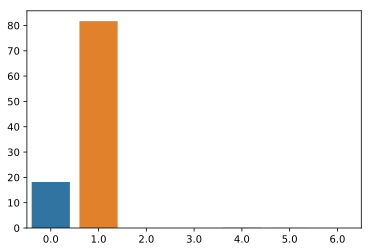

In [319]:
cols_to_use = X_cat.columns
data = [[2804,139,9,268,65,3180,234,238,135,6121,1,12]]
data_df = pd.DataFrame(data, columns=cols_to_use)
for_flask_app1, for_flask_app2 = cat_tree_model.classes_, (cat_tree_model.predict_proba(data_df)*100).flatten()
sns.barplot(x=for_flask_app1, y=for_flask_app2)

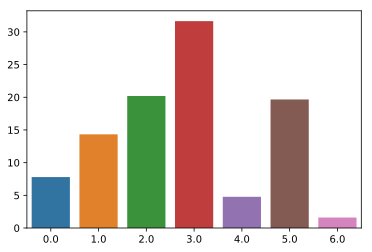

In [338]:
data = [[2200,139,9,268,65,3180,234,238,135,6121,3,12]]
data_df = pd.DataFrame(data, columns=cols_to_use)
for_flask_app1, for_flask_app2 = loaded.classes_, (loaded.predict_proba(data_df)*100).flatten()
sns.barplot(x=for_flask_app1, y=for_flask_app2)

In [272]:
#end test for webbuild

In [120]:
#For use when testing on Kaggle data
#cat_test_kaggle = test_clas.drop(['Id'],1)

In [139]:
cat_y = train_clas['Cover_Type']

In [148]:
cat_X = train_clas.drop(['Cover_Type','Id', 'Cover_Type_Name', 'Wilderness_Area_Name'],1)
cat_y = train_clas['Cover_Type']
#cat_y = [str(x) for x in cat_y] This does not change my results at all
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(cat_X, cat_y, test_size=.3, random_state=42)

categorical_features_indices = np.where(X_train_cat.dtypes != np.int64)[0]
cat_pool = Pool(data = X_train_cat, label=y_train_cat, cat_features=categorical_features_indices)
cat_tree = CatBoostClassifier(iterations=200, depth=10, learning_rate=0.3, loss_function=('MultiClass'))
cat_tree.fit(cat_pool, eval_set = (X_test_cat, y_test_cat))

0:	learn: -1.3824768	test: -1.3738315	best: -1.3738315 (0)	total: 599ms	remaining: 1m 59s
1:	learn: -1.1332167	test: -1.1314109	best: -1.1314109 (1)	total: 1.18s	remaining: 1m 56s
2:	learn: -0.9857275	test: -0.9889688	best: -0.9889688 (2)	total: 1.78s	remaining: 1m 56s
3:	learn: -0.8873564	test: -0.8934829	best: -0.8934829 (3)	total: 2.35s	remaining: 1m 55s
4:	learn: -0.8226870	test: -0.8315243	best: -0.8315243 (4)	total: 2.91s	remaining: 1m 53s
5:	learn: -0.7695684	test: -0.7814998	best: -0.7814998 (5)	total: 3.49s	remaining: 1m 52s
6:	learn: -0.7262357	test: -0.7443971	best: -0.7443971 (6)	total: 4.08s	remaining: 1m 52s
7:	learn: -0.7009924	test: -0.7199276	best: -0.7199276 (7)	total: 4.24s	remaining: 1m 41s
8:	learn: -0.6727776	test: -0.6954092	best: -0.6954092 (8)	total: 4.81s	remaining: 1m 42s
9:	learn: -0.6459270	test: -0.6719063	best: -0.6719063 (9)	total: 5.38s	remaining: 1m 42s
10:	learn: -0.6296513	test: -0.6580325	best: -0.6580325 (10)	total: 5.89s	remaining: 1m 41s
11:	lear

90:	learn: -0.2421065	test: -0.4111984	best: -0.4111984 (90)	total: 49.3s	remaining: 59s
91:	learn: -0.2402019	test: -0.4106627	best: -0.4106627 (91)	total: 49.9s	remaining: 58.6s
92:	learn: -0.2369994	test: -0.4091915	best: -0.4091915 (92)	total: 50.5s	remaining: 58.1s
93:	learn: -0.2350953	test: -0.4081614	best: -0.4081614 (93)	total: 51.1s	remaining: 57.7s
94:	learn: -0.2336025	test: -0.4073833	best: -0.4073833 (94)	total: 51.7s	remaining: 57.2s
95:	learn: -0.2315175	test: -0.4066850	best: -0.4066850 (95)	total: 52.3s	remaining: 56.7s
96:	learn: -0.2303910	test: -0.4065515	best: -0.4065515 (96)	total: 52.9s	remaining: 56.2s
97:	learn: -0.2295923	test: -0.4065178	best: -0.4065178 (97)	total: 53.5s	remaining: 55.7s
98:	learn: -0.2282678	test: -0.4062117	best: -0.4062117 (98)	total: 54.1s	remaining: 55.2s
99:	learn: -0.2261032	test: -0.4046419	best: -0.4046419 (99)	total: 54.7s	remaining: 54.7s
100:	learn: -0.2245952	test: -0.4045461	best: -0.4045461 (100)	total: 55.3s	remaining: 54.2s

179:	learn: -0.1297737	test: -0.3730113	best: -0.3730113 (179)	total: 1m 43s	remaining: 11.5s
180:	learn: -0.1291317	test: -0.3725168	best: -0.3725168 (180)	total: 1m 44s	remaining: 11s
181:	learn: -0.1286422	test: -0.3727870	best: -0.3725168 (180)	total: 1m 44s	remaining: 10.4s
182:	learn: -0.1283808	test: -0.3730621	best: -0.3725168 (180)	total: 1m 45s	remaining: 9.81s
183:	learn: -0.1273436	test: -0.3727444	best: -0.3725168 (180)	total: 1m 46s	remaining: 9.24s
184:	learn: -0.1267676	test: -0.3725712	best: -0.3725168 (180)	total: 1m 46s	remaining: 8.67s
185:	learn: -0.1260346	test: -0.3722708	best: -0.3722708 (185)	total: 1m 47s	remaining: 8.09s
186:	learn: -0.1252418	test: -0.3720493	best: -0.3720493 (186)	total: 1m 48s	remaining: 7.52s
187:	learn: -0.1240469	test: -0.3721720	best: -0.3720493 (186)	total: 1m 48s	remaining: 6.94s
188:	learn: -0.1228560	test: -0.3718256	best: -0.3718256 (188)	total: 1m 49s	remaining: 6.36s
189:	learn: -0.1218578	test: -0.3711371	best: -0.3711371 (189)

In [152]:
cat_tree.predict_proba(X_test_cat)[0] #gives me 8 possible outcomes.

array([1.60753560e-05, 7.07390597e-05, 1.33779564e-03, 2.38574641e-01,
       4.94977321e-02, 1.93562143e-04, 7.10296062e-01, 1.33920754e-05])

In [155]:
cat_guesses = cat_tree.predict(X_test_cat)
cat_guesses = cat_guesses.flatten()
cat_guesses = [str(int(i)) for i in cat_guesses]
print(accuracy_score(cat_guesses, y_test_cat))
confusion_matrix(cat_guesses, y_test_cat)

0.8641975308641975


array([[464, 120,   0,   0,   2,   0,  18],
       [104, 450,   1,   0,  20,   4,   1],
       [  1,  22, 541,  10,  15,  51,   0],
       [  0,   0,  27, 646,   0,  15,   0],
       [ 14,  48,   4,   0, 608,   2,   0],
       [  0,  14,  72,   5,   5, 578,   0],
       [ 37,   4,   0,   0,   0,   0, 633]])

In [192]:
list(zip(cat_tree.classes_, cat_tree.predict_proba(X_test_cat)[0]*100))

[(1.0, 0.0016075355986157236),
 (2.0, 0.0070739059722554985),
 (3.0, 0.1337795636095051),
 (4.0, 23.85746414666754),
 (5.0, 4.949773211873804),
 (6.0, 0.019356214258150047),
 (7.0, 71.02960621448312)]

In [156]:
cat_X_2 = train_clas.drop(['Cover_Type','Id', 'Cover_Type_Name', 'Wilderness_Area_Name'],1)
cat_y_2 = train_clas['Cover_Type']
cat_y_2 = [int(x) for x in cat_y_2]
cat_y_2 = [str(x-1) for x in cat_y_2]
X_train_cat_2, X_test_cat_2, y_train_cat_2, y_test_cat_2 = train_test_split(cat_X_2, cat_y_2, test_size=.3, random_state=42)

categorical_features_indices_2 = np.where(X_train_cat_2.dtypes != np.int64)[0]
cat_pool_2 = Pool(data = X_train_cat_2, label=y_train_cat_2, cat_features=categorical_features_indices_2)
cat_tree_2 = CatBoostClassifier(iterations=200, depth=10, learning_rate=0.3, loss_function=('MultiClass'))
cat_tree_2.fit(cat_pool_2, eval_set = (X_test_cat_2, y_test_cat_2))

0:	learn: -1.3802262	test: -1.3896339	best: -1.3896339 (0)	total: 491ms	remaining: 1m 37s
1:	learn: -1.1312587	test: -1.1400906	best: -1.1400906 (1)	total: 965ms	remaining: 1m 35s
2:	learn: -0.9828289	test: -0.9907659	best: -0.9907659 (2)	total: 1.45s	remaining: 1m 35s
3:	learn: -0.8845029	test: -0.8935217	best: -0.8935217 (3)	total: 1.94s	remaining: 1m 35s
4:	learn: -0.8157629	test: -0.8268257	best: -0.8268257 (4)	total: 2.43s	remaining: 1m 34s
5:	learn: -0.7616528	test: -0.7749450	best: -0.7749450 (5)	total: 2.92s	remaining: 1m 34s
6:	learn: -0.7245092	test: -0.7406099	best: -0.7406099 (6)	total: 3.42s	remaining: 1m 34s
7:	learn: -0.6960497	test: -0.7147496	best: -0.7147496 (7)	total: 3.89s	remaining: 1m 33s
8:	learn: -0.6746907	test: -0.6960559	best: -0.6960559 (8)	total: 4.37s	remaining: 1m 32s
9:	learn: -0.6546948	test: -0.6784773	best: -0.6784773 (9)	total: 4.85s	remaining: 1m 32s
10:	learn: -0.6365135	test: -0.6626030	best: -0.6626030 (10)	total: 5.34s	remaining: 1m 31s
11:	lear

90:	learn: -0.2278962	test: -0.4022208	best: -0.4022208 (90)	total: 45.5s	remaining: 54.5s
91:	learn: -0.2258206	test: -0.4020825	best: -0.4020825 (91)	total: 46.1s	remaining: 54.1s
92:	learn: -0.2241666	test: -0.4014627	best: -0.4014627 (92)	total: 46.6s	remaining: 53.6s
93:	learn: -0.2229316	test: -0.4008195	best: -0.4008195 (93)	total: 47.1s	remaining: 53.1s
94:	learn: -0.2214237	test: -0.4001667	best: -0.4001667 (94)	total: 47.6s	remaining: 52.7s
95:	learn: -0.2192358	test: -0.3989701	best: -0.3989701 (95)	total: 48.1s	remaining: 52.2s
96:	learn: -0.2184321	test: -0.3986332	best: -0.3986332 (96)	total: 48.7s	remaining: 51.7s
97:	learn: -0.2164740	test: -0.3982990	best: -0.3982990 (97)	total: 49.2s	remaining: 51.2s
98:	learn: -0.2150734	test: -0.3973235	best: -0.3973235 (98)	total: 49.8s	remaining: 50.8s
99:	learn: -0.2134173	test: -0.3965835	best: -0.3965835 (99)	total: 50.3s	remaining: 50.3s
100:	learn: -0.2116127	test: -0.3958521	best: -0.3958521 (100)	total: 50.8s	remaining: 49.

179:	learn: -0.1262281	test: -0.3729146	best: -0.3729146 (179)	total: 1m 31s	remaining: 10.2s
180:	learn: -0.1255935	test: -0.3729536	best: -0.3729146 (179)	total: 1m 32s	remaining: 9.69s
181:	learn: -0.1252974	test: -0.3727246	best: -0.3727246 (181)	total: 1m 32s	remaining: 9.18s
182:	learn: -0.1249191	test: -0.3726843	best: -0.3726843 (182)	total: 1m 33s	remaining: 8.67s
183:	learn: -0.1245468	test: -0.3725895	best: -0.3725895 (183)	total: 1m 33s	remaining: 8.16s
184:	learn: -0.1236519	test: -0.3720308	best: -0.3720308 (184)	total: 1m 34s	remaining: 7.66s
185:	learn: -0.1228557	test: -0.3720920	best: -0.3720308 (184)	total: 1m 34s	remaining: 7.15s
186:	learn: -0.1220472	test: -0.3715597	best: -0.3715597 (186)	total: 1m 35s	remaining: 6.64s
187:	learn: -0.1211290	test: -0.3717156	best: -0.3715597 (186)	total: 1m 36s	remaining: 6.13s
188:	learn: -0.1201475	test: -0.3713826	best: -0.3713826 (188)	total: 1m 36s	remaining: 5.62s
189:	learn: -0.1196196	test: -0.3712673	best: -0.3712673 (18

In [157]:
cat_tree_2.predict_proba(X_test_cat_2)[0] #only 7 possible outcomes, this is correct. adjusting my input to be 0-6 instead of 1-7 worked

array([8.67480721e-05, 2.34235726e-03, 4.68104079e-01, 1.79558823e-02,
       1.08433357e-04, 5.11380477e-01, 2.20238018e-05])

In [177]:
cat_guesses_2 = cat_tree_2.predict(X_test_cat_2)
cat_guesses_2 = cat_guesses_2.flatten()
cat_guesses_2 = [str(int(i)) for i in cat_guesses_2]
print(accuracy_score(cat_guesses_2, y_test_cat_2))
confusion_matrix(cat_guesses_2, y_test_cat_2)

0.8675044091710759


array([[467, 114,   0,   0,   2,   0,  16],
       [ 99, 455,   1,   0,  13,   6,   2],
       [  1,  21, 545,   8,  18,  53,   0],
       [  0,   0,  27, 648,   0,  14,   0],
       [ 18,  51,   9,   0, 613,   4,   0],
       [  2,  12,  63,   5,   4, 573,   0],
       [ 33,   5,   0,   0,   0,   0, 634]])

In [191]:
list(zip(cat_tree_2.classes_, cat_tree_2.predict_proba(X_test_cat_2)[0]*100))

[(0.0, 0.008674807214757087),
 (1.0, 0.23423572601422835),
 (2.0, 46.81040786075531),
 (3.0, 1.7955882272096582),
 (4.0, 0.01084333574128691),
 (5.0, 51.13804766288945),
 (6.0, 0.0022023801753065174)]

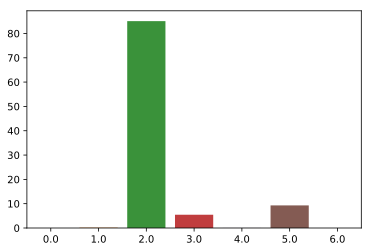

In [270]:
#Test the catboost model with 1 set of data. prediction it gives is what it is accurate
#for use in trying to create a data visualization
cols_to_use = X_train_cat_2.columns
data = [[2500,51,3,1,120,510,221,100,148,3,4,1]]
data_df = pd.DataFrame(data, columns=cols_to_use)
for_flask_app1, for_flask_app2 = cat_tree_2.classes_, (cat_tree_2.predict_proba(data_df)*100).flatten()
sns.barplot(x=for_flask_app1, y=for_flask_app2)

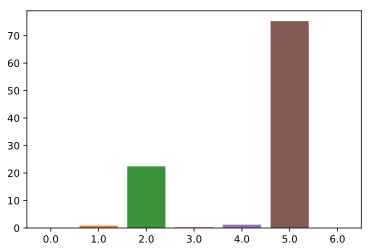

In [228]:
for_flask_app[0][0]

0.0

### Catboost to generate Kaggle Entry

In [ ]:
# categorical_features_indices = np.where(cat_X.dtypes != np.int64)[0]
# cat_pool_kaggle = Pool(data = cat_X, label=cat_y, cat_features=categorical_features_indices)
# cat_tree = CatBoostClassifier(iterations=500, depth=None, learning_rate=0.3, loss_function='MultiClass')
# cat_tree.fit(cat_pool_kaggle)

In [ ]:
# cat_guesses_kaggle = cat_tree.predict(cat_test_kaggle)
# cat_guesses_kaggle = cat_guesses_kaggle.flatten()
# cat_guesses_kaggle = [str(int(i)) for i in cat_guesses_kaggle]
# test_clas['Cover_Type'] = cat_guesses_kaggle
# test_ans = test_clas[['Id','Cover_Type']]
# test_ans.to_csv('submission_9.csv', index=False)

In [ ]:
# Kaggle result was as good as my best forest.

### End of cat_boost testing

In [215]:
train_clas.head(1)

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Wilderness_Area,Soil_Type,Cover_Type_Name,Wilderness_Area_Name
0,1,2596,51,3,258,0,510,221,232,148,6279,5,1,29,Aspen,Rahwah Wilderness


In [58]:
X_test_case_clas = test.drop(['Cover_Type', 'Id'],1)

In [60]:
X_train_forest = train.drop(['Cover_Type', 'Id'],1)
y_train_forest = train['Cover_Type']

In [61]:
X_train_forest_X, X_test_forest_X, y_train_forest_y, y_test_forest_y = train_test_split(X_train_forest,y_train_forest,test_size=.3, random_state=42)

In [62]:
#Create a decision tree model on train/test data split and evaluate score on test data.
decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train_forest_X, y_train_forest_y)
decisiontree.score(X_test_forest_X, y_test_forest_y)

0.7835097001763669

In [63]:
#train a generic random forest model and score on test data
random_forest = RandomForestClassifier()
random_forest.fit(X_train_forest_X, y_train_forest_y)
random_forest.score(X_test_forest_X, y_test_forest_y)

0.828042328042328

In [64]:
# #run a grid search with the below parameters on a random forest classifier model to determine best model params
# Commented out because it took 15 minutes to run.
# randomforest = RandomForestClassifier(random_state = 42)
# param_grid = { 
#     'n_estimators': [100, 200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [6,7,8, None],
#     'criterion' :['gini', 'entropy']
# }
# CV_rfc = GridSearchCV(estimator=randomforest, param_grid = param_grid, cv=10)
# CV_rfc.fit(X_train_forest_X, y_train_forest_y)

In [67]:
#Find best parameters from CV grid search above
#CV_rfc.best_params_

In [68]:
#train a more optimized random forest model and score it on test data
random_forest_optimized = RandomForestClassifier(n_estimators=500, random_state=42)
random_forest_optimized.fit(X_train_forest_X, y_train_forest_y)
random_forest_optimized.predict(X_test_forest_X)
random_forest_optimized.score(X_test_forest_X, y_test_forest_y)

0.8655202821869489

In [109]:
random_forest_optimized.feature_importances_

array([2.24952400e-01, 5.01017138e-02, 3.76053381e-02, 6.33651514e-02,
       5.48124352e-02, 9.24733398e-02, 5.32871398e-02, 4.59073889e-02,
       4.74192543e-02, 7.23782099e-02, 1.94768085e-02, 3.69263888e-03,
       1.79614543e-02, 4.19677230e-02, 1.57097186e-03, 6.42972008e-03,
       1.71302592e-02, 1.15717336e-02, 1.12787816e-03, 2.76008521e-03,
       0.00000000e+00, 3.78407379e-06, 1.10585241e-04, 2.30331852e-02,
       3.41816920e-03, 4.30113023e-03, 5.31334234e-03, 6.59626140e-04,
       0.00000000e+00, 8.42567094e-04, 5.85214362e-03, 8.00790839e-04,
       3.36156673e-04, 1.82923765e-03, 2.48530998e-04, 5.36566315e-03,
       5.10587871e-03, 2.64618665e-03, 3.18198468e-05, 5.24249540e-04,
       2.17465366e-04, 1.57500565e-04, 5.28970355e-03, 8.17011379e-03,
       2.46427696e-03, 4.89629341e-03, 3.73616483e-03, 2.39850747e-04,
       2.02495551e-03, 6.34810977e-05, 6.40884200e-04, 1.83741300e-02,
       1.75408744e-02, 9.76961452e-03])

In [100]:
#train a model using train test split on extratreesclassifier
forest = ExtraTreesClassifier(n_estimators=200, random_state=42)
forest.fit(X_train_forest_X, y_train_forest_y)
#y_pred_forest = forest.predict(X_test_forest_X)
#forest.score(X_test_forest_X, y_test_forest_y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [108]:
from sklearn import tree

In [74]:
confusion_matrix(y_pred_forest, y_test_forest_y)

array([[461, 106,   0,   0,   3,   0,  18],
       [107, 464,   2,   0,  17,   3,   3],
       [  1,  23, 525,   6,  14,  60,   0],
       [  0,   0,  39, 648,   0,  22,   0],
       [ 21,  50,   2,   0, 612,   3,   0],
       [  1,  13,  77,   7,   4, 562,   0],
       [ 29,   2,   0,   0,   0,   0, 631]])

# Kaggle Models

In [ ]:
# Using decision tree model from above, test on kaggle test data
#note this model was still created from train/test split data and not on all avaialble test data.
#therefore it underperforms a little
new_pred = decisiontree.predict(X_test_forest_X)
test_clas['Cover_Type'] = new_pred
test_ans = test_clas[['Id','Cover_Type']]
test_ans.to_csv('submission_1.csv', index=False)

In [ ]:
# Using a random forest model, make predictions on the Kaggle test data for submission.
test_clas['Cover_Type'] = randomforest.predict(X_test_clas)
test_ans = test_clas[['Id','Cover_Type']]
test_ans.to_csv('submission_2.csv', index=False)

In [ ]:
#Train a model using the entire train dataset to them use on the entire kaggle test set for submission
forest2 = ExtraTreesClassifier(n_estimators=200, random_state=42)
forest2.fit(X_train_forest, y_train_forest)

#use the model forest2 to test on the test cases from Kaggle and export as a csv to submit
predicts_new = forest2.predict(X_test_case_clas)
test_clas['Cover_Type'] = predicts_new
test_ans = test_clas[['Id','Cover_Type']]
test_ans.to_csv('submission_7.csv', index=False)

# Testing sample using Naive Bayes model

In [ ]:
NB_model = naive_bayes.GaussianNB()
NB_model.fit(X_train, y_train)
accuracy_score(y_test, NB_model.predict(X_test))

In [ ]:
NB_model_2 = naive_bayes.BernoulliNB()
NB_model_2.fit(X_train, y_train)
accuracy_score(y_test, NB_model_2.predict(X_test))

In [ ]:
X_train['Vertical_Distance_To_Hydrology'] = abs(X_train['Vertical_Distance_To_Hydrology'])

In [ ]:
NB_model_3 = naive_bayes.MultinomialNB()
NB_model_3.fit(X_train, y_train)
accuracy_score(y_test, NB_model_3.predict(X_test))

In [ ]:
NB_model = naive_bayes.GaussianNB()
NB_model.fit(X_train_minmax, y_train)
accuracy_score(y_test, NB_model.predict(X_test_minmax))

In [ ]:
NB_model_2 = naive_bayes.BernoulliNB()
NB_model_2.fit(X_train_minmax, y_train)
accuracy_score(y_test, NB_model_2.predict(X_test_minmax))

In [ ]:
NB_model_3 = naive_bayes.MultinomialNB()
NB_model_3.fit(X_train_minmax, y_train)
accuracy_score(y_test, NB_model_3.predict(X_test_minmax))

### End of Naive Bayes

## Playing with H2o Models

In [ ]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [ ]:
h2o.init()

In [ ]:
h20train = train_clas.drop(['Wilderness_Area','Cover_Type'],1)

In [ ]:
h20test = test_clas.drop(['Wilderness_Area'],1)

In [ ]:
h20test.columns, h20train.columns

In [ ]:
h20train.to_csv('h2frame.csv')
h20test.to_csv('h2testframe.csv')

In [ ]:
covtype_df = h2o.import_file('h2frame.csv')
covtest_df = h2o.import_file('h2testframe.csv')

In [ ]:
covtype_df = covtype_df.drop(['C1'])

In [ ]:
covtest_df = covtest_df.drop(['C1'])

In [ ]:
train, valid, test = covtype_df.split_frame([.6,.2],seed=42)

In [ ]:
covtype_X = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points','Soil_Type','Wilderness_Area_Name']
covtype_y = 'Cover_Type_Name'

In [ ]:
rf_v1 = H2ORandomForestEstimator(
    model_id="rf_covType_v1",
    ntrees=200,
    stopping_rounds=2,
    score_each_iteration=True,
    seed=1000000)

In [ ]:
rf_v1.train(covtype_X, covtype_y, training_frame=train, validation_frame=valid)

In [ ]:
rf_v1

In [ ]:
gbm_v1 = H2OGradientBoostingEstimator(
    model_id="gbm_covType_v1",
    seed=2000000
)
gbm_v1.train(covtype_X, covtype_y, training_frame=train, validation_frame=valid)

In [ ]:
gbm1 = gbm_v1.predict(covtest_df.drop(['Cover_Type_Name'],1))

In [ ]:
gbm1.as_data_frame

In [ ]:
gbm_v2 = H2OGradientBoostingEstimator(
    ntrees=50,
    learn_rate=0.20,
    max_depth=10,
    stopping_tolerance=0.01, #10-fold increase in threshold as defined in rf_v1
    stopping_rounds=2,
    score_each_iteration=True,
    model_id="gbm_covType_v2",
    seed=200000)

In [ ]:
gbm_v2.train(covtype_X, covtype_y, training_frame=train, validation_frame=valid)

In [ ]:
gbm_v2_preds = gbm_v2.predict(covtest_df.drop(['Cover_Type_Name'],1))

In [ ]:
# (gbm_v2_preds['predict']).as_data_frame(use_pandas=True).to_csv('outcomes.csv')

In [ ]:
# gbm_df = pd.read_csv('outcomes.csv')

In [ ]:
# gbm_df['Cover_Type'] = 'null'
# gbm_df['Cover_Type'][(gbm_df['predict']=='Spruce/Fir')] = '1'
# gbm_df['Cover_Type'][(gbm_df['predict']=='Lodgepole Pine')] = '2'
# gbm_df['Cover_Type'][(gbm_df['predict']=='Ponderose Pine')] = '3'
# gbm_df['Cover_Type'][(gbm_df['predict']=='Cottonwood/Willow')] = '4'
# gbm_df['Cover_Type'][(gbm_df['predict']=='Aspen')] = '5'
# gbm_df['Cover_Type'][(gbm_df['predict']=='Douglas-fir')] = '6'
# gbm_df['Cover_Type'][(gbm_df['predict']=='Krummholz')] = '7'

In [ ]:
h2o.cluster().shutdown(prompt=False)

### done playing with h2o. It does not seem to retain id's and therefore I can't figure out how to use on kaggle test dataset out of sample.